In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
%matplotlib inline

In [4]:
img = cv.imread('images/the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
assert img is not None, 'Image not found'

# # Visulaize Image (optional)

# cv.namedWindow("images",cv.WINDOW_AUTOSIZE)
# cv.imshow("images",img)
# cv.waitKey(0)
# cv.destroyAllWindows()

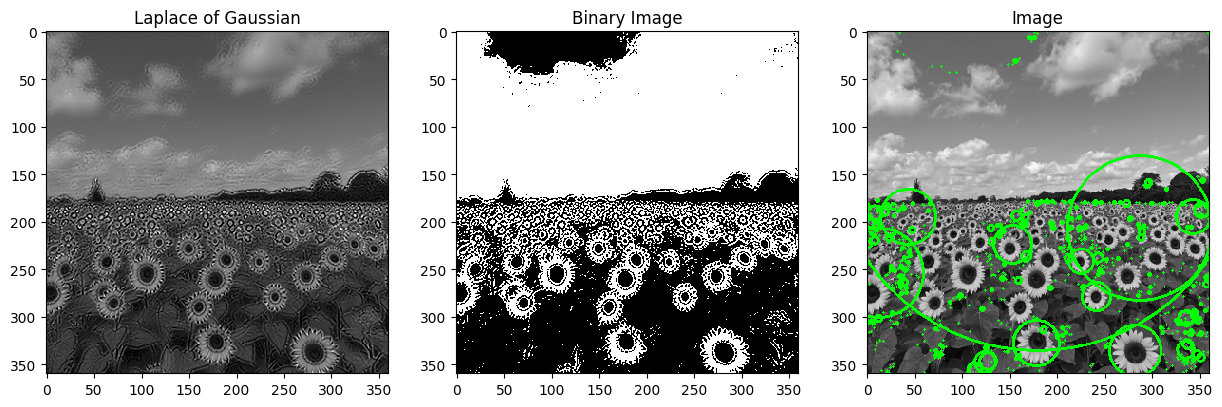

Number of Blobs: 591


In [24]:
def create_gaussian_kernel(size, sigma, verbose=False):
    kernel_1D = np.linspace(-(size // 2), size // 2, size)
    kernel_1D = np.exp(-(kernel_1D**2) / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))
    kernel_2D = np.outer(kernel_1D.T, kernel_1D.T)

    kernel_2D *= 1.0 / kernel_2D.max()

    if verbose:
        plt.imshow(kernel_2D, interpolation='none', cmap='gray')
        plt.title("Image")
        plt.show()

    return kernel_2D

sigma = 0.6375

gaussian_kernel = create_gaussian_kernel(5, sigma, verbose=False) 

# find the laplace of the gaussian kernel
laplace_of_gaussian_kernel = cv.Laplacian(gaussian_kernel, cv.CV_64F) * sigma**2

# apply the laplace of gaussian kernel to the image
laplace_of_gaussian_img = cv.filter2D(img, -1, laplace_of_gaussian_kernel)


# Thresholding
threshold_value = 81 # Adjust as needed
_, binary_img = cv.threshold(np.abs(laplace_of_gaussian_img), threshold_value, 255, cv.THRESH_BINARY)

# Find Contours
contours, _ = cv.findContours(binary_img.astype(np.uint8), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Draw Circles
original_img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)

for contour in contours:
    # Calculate the center and radius of the blob
    ((x, y), radius) = cv.minEnclosingCircle(contour)
    center = (int(x), int(y))
    radius = int(radius)

    # Draw the circle
    cv.circle(original_img, center, radius, (0, 255, 0), 2)  # (0, 255, 0) is color (green), 2 is thickness

# Display Result
# cv.imshow("Blob Detection Result", original_img)
# cv.waitKey(0)
# cv.destroyAllWindows()

plt.figure(figsize=(15, 10))

plt.subplot(1, 3, 1)
plt.imshow(laplace_of_gaussian_img, interpolation='none', cmap='gray')
plt.title("Laplace of Gaussian")

plt.subplot(1, 3, 2)
plt.imshow(binary_img, interpolation='none', cmap='gray')
plt.title("Binary Image")

plt.subplot(1, 3, 3)
plt.imshow(original_img, interpolation='none', cmap='gray')
plt.title("Image")

plt.show()

print("Number of Blobs: {}".format(len(contours)))





# Question 02

In [8]:
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import math
from scipy import optimize
import random
from matplotlib.patches import Circle

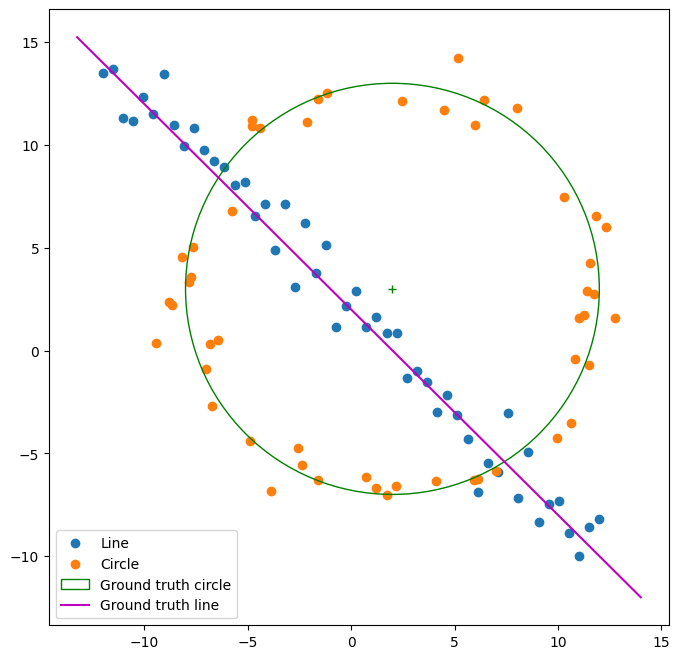

In [3]:

N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r / 16

t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x = x0_gt + (r + n) * np.cos(t)
y = y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s = 1.0
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))


fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')

ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')

plt.legend()
plt.show()


# RANSAC Estimation for Line

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.4265897424470643e-07
            Iterations: 9
            Function evaluations: 43
            Gradient evaluations: 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9.514346990064175e-11
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.5822844495547137e-11
            Iterations: 9
            Function evaluations: 42
            Gradient evaluations: 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.817943976690331e-10
            Iterations: 7
            Function evaluations: 35
            Gradient evaluations: 7
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.905681066846053e-09
            Iterations: 8
            Fu

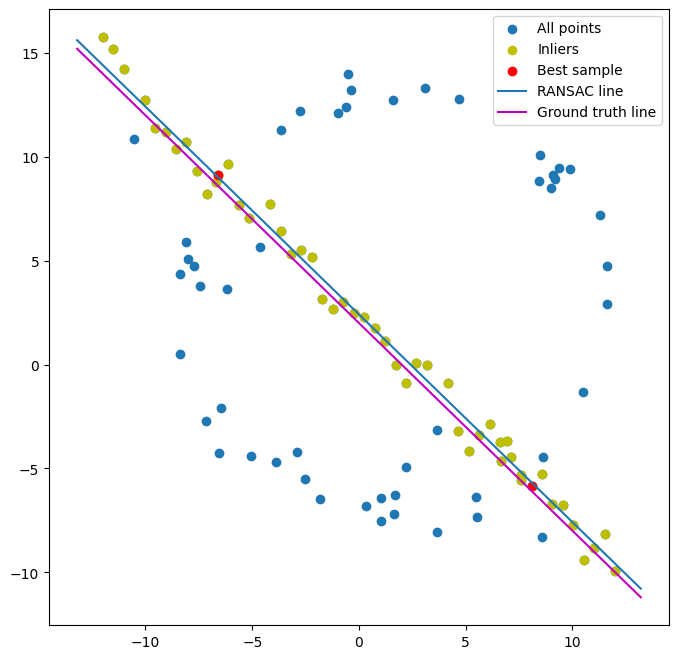

In [2]:
# create dataset
N = X.shape[0]
data = X

def calculate_distance(x1, y1, x2, y2):
    distance_mag =  math.sqrt((x2-x1)**2 + (y2-y1)**2)
    a = (x2-x1)/distance_mag
    b = (y2-y1)/distance_mag

    d = a*x1 + b*y1

    return a , b, d 

def calc_tls (x,indices):
    a = x[0]
    b = x[1]
    d = x[2]

    return np.sum(np.square(a*data[indices,0] + b*data[indices,1] - d))

def g(x):
    return x[0]**2 + x[1]**2 - 1

constraints = ({'type': 'eq', 'fun': g})

def best_fit_line(X,x,t):
    a = x[0]
    b = x[1]
    d = x[2]

    e = np.absolute(a*X[:,0] + b*X[:,1] - d)

    return e < t

threshold_value = 1.0
d = 0.5*N
s = 2

line_inliers = []
circle_inliers = []

max_iters = 100
iters = 0
best_line_model = []
best_error = np.inf
best_sample_line = []
best_inlier_line = []

while iters < max_iters:
    indices = np.random.randint(0, N, 2)
    x0 = np.array([1,1,0])
    res = minimize(fun = calc_tls, args = indices, x0 = x0, tol= 1e-6, constraints=constraints, options={'disp': True})
    line_inliers = best_fit_line(data,res.x,threshold_value)

    if line_inliers.sum() > d :
        x0 = res.x
        res = minimize(fun = calc_tls, args = line_inliers, x0 = x0, tol= 1e-6, constraints=constraints, options={'disp': True})
        if res.fun < best_error:
            best_error = res.fun
            best_line_model = res.x
            best_sample_line = data[indices,:]
            best_inlier_line = line_inliers
            res_only_with_sample = x0
            print("Best line model: ", best_line_model)
            print("Best error: ", best_error)
            print("Best sample: ", best_sample_line)
            print("Best inlier: ", best_inlier_line)
            print("Number of inliers: ", best_inlier_line.sum())
            print("Number of outliers: ", N - best_inlier_line.sum())
            print("Number of iterations: ", iters)
            print("------------------------------------------------------")

    iters += 1

print("The Best Line model got : ",best_line_model)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(data[:,0],data[:,1], label='All points')
ax.scatter(data[best_inlier_line,0],data[best_inlier_line,1], color='y', label='Inliers')
ax.scatter(best_sample_line[:,0],best_sample_line[:,1], color='r', label='Best sample')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_line_model[1]*x_ + best_line_model[2])/best_line_model[1]
plt.plot(x_, y_,  label='RANSAC line')
x_ = np.array([x_min, x_max])
y_ = m*x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')
plt.legend()
plt.show()


# RANSAC Estimation for Circle

In [38]:
def calculate_circle_parameters(points):
    x1, y1 = points[0]
    x2, y2 = points[1]
    x3, y3 = points[2]
    
    D = 2 * (x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))
    Ux = ((x1**2 + y1**2) * (y2 - y3) + (x2**2 + y2**2) * (y3 - y1) + (x3**2 + y3**2) * (y1 - y2)) / D
    Uy = ((x1**2 + y1**2) * (x3 - x2) + (x2**2 + y2**2) * (x1 - x3) + (x3**2 + y3**2) * (x2 - x1)) / D
    
    r = np.sqrt((x1 - Ux)**2 + (y1 - Uy)**2)
    
    return Ux, Uy, r

def fit_circle_ransac(points, num_iterations, error_threshold, min_consensus):
    best_circle = None
    best_inliers = []

    for _ in range(num_iterations):
        sample_indices = np.random.choice(len(points), 3, replace=False)
        sample_points = points[sample_indices]
        x, y, r = calculate_circle_parameters(sample_points)
        radial_errors = np.abs(np.sqrt((points[:, 0] - x)**2 + (points[:, 1] - y)**2) - r)
        inliers = np.where(radial_errors < error_threshold)[0]
        if len(inliers) >= min_consensus and len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_circle = (x, y, r)

    return best_circle, best_inliers


num_iterations_circle = 1000
error_threshold_circle = 0.85  
min_consensus_circle = 40     

best_circle, circle_inliers = fit_circle_ransac(X_circ, num_iterations_circle, error_threshold_circle, min_consensus_circle)


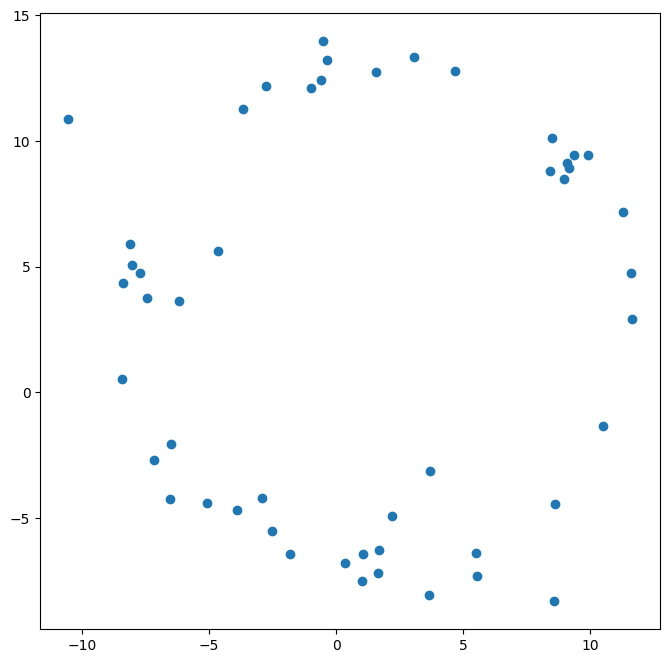

In [39]:
outliers_indices = np.where(np.logical_not(best_inlier_line))[0]
outliers_data = data[outliers_indices, :]

plt.subplots(figsize=(8,8))
plt.scatter(outliers_data[:,0],outliers_data[:,1],)
plt.show()

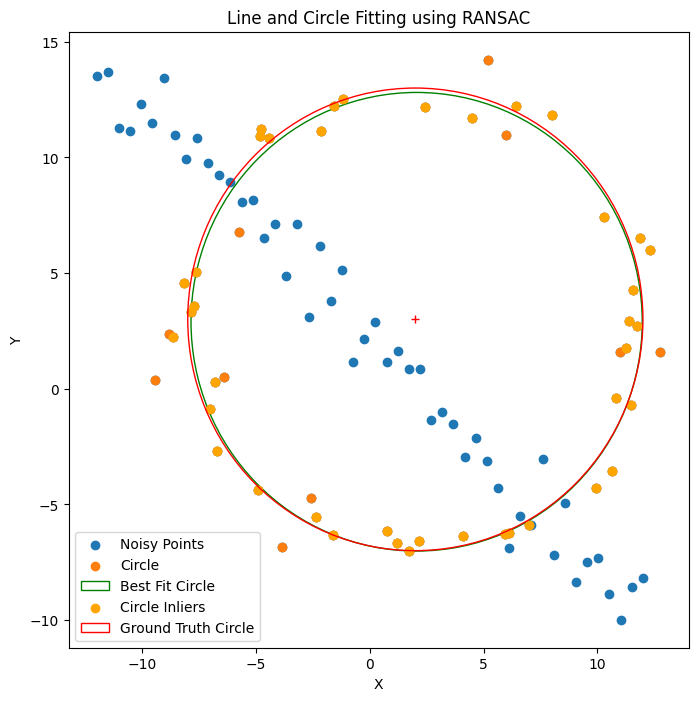

In [40]:
# Plotting the results
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Scatter plot for the noisy point set
ax.scatter(X[:, 0], X[:, 1], label='Noisy Points')
ax.scatter( X_circ[ : , 0 ] , X_circ [ : , 1 ] , label= 'Circle' )

if best_circle is not None:  # Check if the circle was successfully estimated
    x_circle, y_circle, r_circle = best_circle
    circle = Circle((x_circle, y_circle), r_circle, color='green', fill=False, label='Best Fit Circle')
    ax.add_patch(circle)
    ax.scatter(X_circ[circle_inliers, 0], X_circ[circle_inliers, 1], color='orange', label='Circle Inliers')
circle_gt = Circle((x0_gt, y0_gt), r, color='red', fill=False, label='Ground Truth Circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='red')
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Line and Circle Fitting using RANSAC')

plt.show()

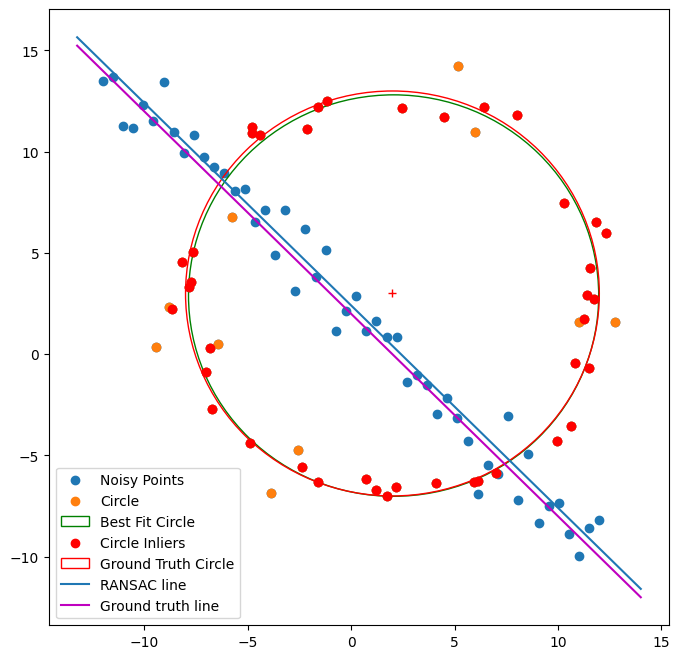

In [41]:
fig,ax = plt.subplots(figsize = (8,8))
ax.scatter(X[:, 0], X[:, 1], label='Noisy Points')
ax.scatter( X_circ[ : , 0 ] , X_circ [ : , 1 ] , label= 'Circle' )
x_circle, y_circle, r_circle = best_circle
circle = Circle((x_circle, y_circle), r_circle, color='green', fill=False, label='Best Fit Circle')
ax.add_patch(circle)
ax.scatter(X_circ[circle_inliers, 0], X_circ[circle_inliers, 1], color='red', label='Circle Inliers')
circle_gt = Circle((x0_gt, y0_gt), r, color='red', fill=False, label='Ground Truth Circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='red')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_line_model[1]*x_ + best_line_model[2])/best_line_model[1]
plt.plot(x_, y_,  label='RANSAC line')
x_ = np.array([x_min, x_max])
y_ = m*x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')
plt.legend()
plt.show()

# Question 03

In [3]:
import cv2 as cv
import numpy as np

number_of_points = 4
n = 0
architectural_points = np.empty((number_of_points,2))

# Load your architectural image and flag image
architectural_image = cv.imread('images/point5.jpeg', cv.IMREAD_COLOR)
flag_image = cv.imread('images/entc.png', cv.IMREAD_COLOR)

# Mouse callback function
def draw_circle(event,x,y,flags,param):
    global n
    architectural_points = param[0]
    if event == cv.EVENT_LBUTTONDOWN:
        cv.circle(param[1],(x,y),5,(255,0,0),-1)
        architectural_points[n] = (x,y)
        n += 1

# Getting the mouse points of the base image
cv.namedWindow('Image', cv.WINDOW_AUTOSIZE)
param = [architectural_points, architectural_image]
cv.setMouseCallback('Image',draw_circle, param)
while(1):
    cv.imshow('Image', architectural_image)
    if n == number_of_points:
        break
    if cv.waitKey(20) & 0xFF == 27:
        break

# Define the corresponding points on the flag image
# These points should form a rectangle to match the planar surface
flag_points = np.array([[0, 0], [flag_image.shape[1], 0], [flag_image.shape[1], flag_image.shape[0]], [0, flag_image.shape[0]]], dtype=np.float32)

# Compute the homography matrix
homography_matrix, _ = cv.findHomography(flag_points, architectural_points)

# Warp the flag image to match the architectural image using the homography
flag_warped = cv.warpPerspective(flag_image, homography_matrix, (architectural_image.shape[1], architectural_image.shape[0]))

# Blend the two images (you can adjust the blending method and parameters)
blended_image = cv.addWeighted(architectural_image, 1, flag_warped, 0.7, 0)

# Display the result
cv.imshow('Superimposed Image', blended_image)
cv.waitKey(0)
cv.destroyAllWindows()


# Question 04